# **Analyse Exploratoire**

In [1]:
# Bibliothèques de base
import pandas as pd
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# Utilisé pour la fonction haversine_distance()
import math

# Utilisés lors de l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Servira pour faire l'ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Pour faire tests de normalité
from scipy.stats import shapiro

# Utilisé pour passer des données au log avant ANOVA
from sklearn.preprocessing import FunctionTransformer

# Utilisé pour savoir si le fichier excel d'export existe déjà
import os

# Je désactive le copy warning, en m'étant au préalable assuré que les traitements étaient corrects
pd.options.mode.chained_assignment = None  # default='warn'

## **Importation des datasets**

In [2]:
customers = pd.read_csv("dataset\olist_customers_dataset.csv", sep=',')
geolocation = pd.read_csv("dataset\olist_geolocation_dataset.csv", sep=',')
order_items = pd.read_csv("dataset\olist_order_items_dataset.csv", sep=',')
order_payments = pd.read_csv("dataset\olist_order_payments_dataset.csv", sep=',')
order_reviews = pd.read_csv("dataset\olist_order_reviews_dataset.csv", sep=',')
orders = pd.read_csv("dataset\olist_orders_dataset.csv", sep=',')
products = pd.read_csv("dataset\olist_products_dataset.csv", sep=',')
sellers = pd.read_csv("dataset\olist_sellers_dataset.csv", sep=',')
product_category_name_translation = pd.read_csv("dataset\product_category_name_translation.csv", sep=',')

print('Importation terminée')

Importation terminée


## **Pré-traitement des datasets avant fusion**

### **Traitement de *geolocation***

Je supprime *geolocation_city* et *geolocation_state* que je ne vais pas utiliser.<br>
Je regroupe par *geolocation_zip_code_prefix* en faisant la moyen pour les coordonnées GPS.

In [3]:
print('Lignes avant traitement :', len(geolocation))
geolocation = geolocation.drop(['geolocation_city', 'geolocation_state'], axis=1)
geolocation = geolocation.groupby('geolocation_zip_code_prefix').mean()
geolocation = geolocation.reset_index() # pour remettre geolocation_zip_code_prefix en tant que colonne
print('Lignes après traitement :', len(geolocation))
print('Valeurs manquantes :', geolocation.isnull().sum().sum())

Lignes avant traitement : 1000163
Lignes après traitement : 19015
Valeurs manquantes : 0


### **Traitement de *customers***

Je fusionne avec *geolocation* pour récupérer les coordonnées GPS à partir du zip code prefix<br>
Je renomme *geolocation_lat* et *geolocation_lng* en *customer_lat* et *customer_lng*<br>
Je ne conserve au final que *customer_id*, *customer_unique_id*, *customer_lat* et *customer_lng*

In [4]:
customers = customers.merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
customers.rename(columns={"geolocation_lat": "customer_lat", "geolocation_lng": "customer_lng"}, inplace=True)
customers = customers[['customer_id', 'customer_unique_id', 'customer_lat', 'customer_lng']]
# Il y a quelques valeurs manquantes dans customer_lat/customer_lng : j'impute par la moyenne
customers['customer_lat'].loc[customers['customer_lat'].isnull() == True] = customers['customer_lat'].mean()
customers['customer_lng'].loc[customers['customer_lng'].isnull() == True] = customers['customer_lng'].mean()
print('Valeurs manquantes :', customers.isnull().sum().sum())

Valeurs manquantes : 0


### **Traitement de *sellers***

Je fusionne avec *geolocation* pour récupérer les coordonnées GPS à partir du zip code prefix<br>
Je renomme *geolocation_lat* et *geolocation_lng* en *seller_lat* et *seller_lng*<br>
Je ne conserve au final que *seller_id*, *seller_lat*, et *seller_lng*

In [5]:
sellers = sellers.merge(geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
sellers.rename(columns={"geolocation_lat": "seller_lat", "geolocation_lng": "seller_lng"}, inplace=True)
sellers = sellers[['seller_id', 'seller_lat', 'seller_lng']]
# Il y a quelques valeurs manquantes dans seller_lat/seller_lng : j'impute par la moyenne
sellers['seller_lat'].loc[sellers['seller_lat'].isnull() == True] = sellers['seller_lat'].mean()
sellers['seller_lng'].loc[sellers['seller_lng'].isnull() == True] = sellers['seller_lng'].mean()
print('Valeurs manquantes :', sellers.isnull().sum().sum())

Valeurs manquantes : 0


### **Traitement de *order_items***

Je regroupe par numéro de commande (order_id), les autres colonnes sont agglomérées comme suit : 
- *order_item_id* : *max()*, ce qui donnera le nombre d'articles de la commande
- *product_id* : *first()*, je ne conserve que le premier, pas idéal mais ça ne concerne qu'un nombre très limité de commandes
- *seller_id* : *first()*, même logique que pour *product_id*
- *shipping_limit_date* : *first()*, c'est la même pour toute la commande
- *price* : *sum()*, prix total des articles
- *freight_value* : *mean()*, frais de port moyens

In [6]:
print('Lignes avant traitement :', len(order_items))
order_items = order_items.groupby('order_id').agg({'order_item_id': 'max', 'product_id': 'first', 'seller_id': 'first', 'shipping_limit_date': 'first', 'price': 'sum', 'freight_value': 'mean'})
order_items = order_items.reset_index() # pour remettre order_id en tant que colonne
print('Lignes après traitement :', len(order_items))
print('Valeurs manquantes :', order_items.isnull().sum().sum())

Lignes avant traitement : 112650


Lignes après traitement : 98666
Valeurs manquantes : 0


### **Traitement de *order_payments***

Je supprime *payment_sequential*, que je ne vais pas utiliser.<br>
Je regroupe par *order_id*, les autres colonnes sont agglomérées comme suit : 
- *payment_type* : *first()*
- *payment_installments* (paiements en plusieurs fois) : *max()*
- *payment_value* : *sum()*

In [7]:
print('Lignes avant traitement :', len(order_payments))
order_payments = order_payments.drop(['payment_sequential'], axis=1)
order_payments = order_payments.groupby('order_id').agg({'payment_type': 'first', 'payment_installments': 'max', 'payment_value': 'sum'})
order_payments = order_payments.reset_index() # pour remettre order_id en tant que colonne
print('Lignes après traitement :', len(order_payments))
print('Valeurs manquantes :', order_payments.isnull().sum().sum())

Lignes avant traitement : 103886
Lignes après traitement : 99440
Valeurs manquantes : 0


### **Traitement de *order_reviews***

Je supprime *review_id*, *review_comment_title*, *review_comment_message*, *review_creation_date* et *review_answer_timestamp*, que je n'utiliserai pas.<br>
Je regroupe par *order_id* avec *mean()* sur *review_score* (il arrive parfois qu'il y ait plusieurs avis pour une même commande)

In [8]:
print('Lignes avant traitement :', len(order_reviews))
order_reviews = order_reviews.drop(['review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp'], axis=1)
order_reviews = order_reviews.groupby('order_id').mean()
order_reviews = order_reviews.reset_index() # pour remettre order_id en tant que colonne
print('Lignes après traitement :', len(order_reviews))
print('Valeurs manquantes :', order_reviews.isnull().sum().sum())

Lignes avant traitement : 99224
Lignes après traitement : 98673
Valeurs manquantes : 0


### **Traitement de *orders***

Je convertis les colonnes contenant des dates que je vais utiliser au format date.<br>
Je décide de ne conserver que les commandes qui sont indiquées comme livrées (la grande majorité)<br>
Je crée une nouvelle colonne *delivery_time* en faisant la différence entre *order_purchase_timestamp* et *order_delivered_customer_date*.<br>
Au final, je ne conserve que *order_id*, *customer_id*, *order_purchase_timestamp* et *delivery_time*



In [9]:
print('Lignes avant traitement :', len(orders))
# je passe par .apply() pour appliquer pd.to_datetime au deux colonnes
orders[['order_purchase_timestamp', 'order_delivered_customer_date']] = orders[['order_purchase_timestamp', 'order_delivered_customer_date']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
orders = orders.loc[orders['order_status'] == 'delivered']
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
orders = orders[['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_time']]
# Je supprime les quelques lignes où delivery_time est manquant
orders = orders.loc[orders['delivery_time'].isnull() == False]
print('Lignes après traitement :', len(orders))
print('Valeurs manquantes :', orders.isnull().sum().sum())


Lignes avant traitement : 99441
Lignes après traitement : 96470
Valeurs manquantes : 0


### **Traitement de *products***

Je fusionne avec *product_category_name_translation* pour avoir les catégories en Anglais.<br>
Je remplace les valeurs manquantes dans *product_category_name_english* par "other".<br>
Au final, je ne conserve que les colonnes *product_id* et *product_category_name_english*.

In [10]:
products = products.merge(product_category_name_translation, on='product_category_name', how='left')
products['product_category_name_english'].loc[products['product_category_name_english'].isnull() == True] = "other"
products = products[['product_id', 'product_category_name_english']]
print('Valeurs manquantes :', products.isnull().sum().sum())

Valeurs manquantes : 0


## **Fusion des datasets**

Je pars de *order_items* et je vais successivement fusionner avec les autres datasets.

In [11]:
order_items = order_items.merge(orders, on='order_id', how='left')
order_items = order_items.merge(products, on='product_id', how='left')
order_items = order_items.merge(order_payments, on='order_id', how='left')
order_items = order_items.merge(sellers, on='seller_id', how='left')
order_items = order_items.merge(order_reviews, on='order_id', how='left')
order_items = order_items.merge(customers, on='customer_id', how='left')

- Je supprime les lignes où *customer_unique_id* est manquant car c'est une variable essentielle (c'est elle qu'on va regrouper en cluster plus tard).

In [12]:
order_items = order_items.loc[order_items['customer_unique_id'].isnull() == False]

### **Création d'une nouvelle variable *customer_seller_distance***

À partir de customer_lat/customer_lng et seller_lat/seller_lng, je vais calculer la distance client/vendeur pour chaque commande.

- Création d'une fonction qui va permettre de calculer la distance entre deux points à partir de leur coordonnées GPS : 

In [13]:
def haversine_distance(coord1, coord2):

    """
    Cette fonction permet de calculer la distance entre un point A et un point B à partir de leur coordonnées GPS.

    :coord1: coordonnées du point A, sous forme de tuple (latitude, longitude).
    :coord2: coordonnées du point A, sous forme de tuple (latitude, longitude).
    :return: Retourne la distance de haversine entre A et B, en kilomètres.

    """

    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # Rayon moyen de la Terre en kilomètres

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

- On applique la fonction haversine_distance() pour chaque ligne et on met le résultat dans la colonne *customer_seller_distance*

In [14]:
order_items['customer_seller_distance'] = order_items.apply(lambda row: haversine_distance((row['customer_lat'], row['customer_lng']), (row['seller_lat'], row['seller_lng'])), axis=1)

- On va supprimer les colonnes dont on a plus besoin à ce stade : *product_id*, *seller_id*, *shipping_limit_date*, *customer_id*, *seller_lat*, *seller_lng* :

In [15]:
colonnes_a_supprimer = [
                        'order_item_id',
                        'product_id',
                        'seller_id',
                        'price',
                        'shipping_limit_date',
                        'customer_id',
                        'seller_lat',
                        'seller_lng'
                       ]

# On en profite pour créer un dataset global nommé "data"
data = order_items.drop(colonnes_a_supprimer, axis=1)

### **Regroupement des lignes pour n'avoir plus qu'une ligne par client**

- Je duplique la colonne *order_purchase_timestamp* : lors du groupby, une sera utilisé pour définir la date de première commande, l'autre pour la date de dernière commande.

In [16]:
data['order_purchase_timestamp_last'] = data.loc[:, 'order_purchase_timestamp']
# Je renomme la colonne order_purchase_timestamp d'origine en order_purchase_timestamp_first
data.rename(columns={"order_purchase_timestamp": "order_purchase_timestamp_first"}, inplace=True)

- Nous allons maintenant regrouper les lignes de manière à n'avoir plus qu'une ligne par *customer_unique_id*, c'est-à-dire par client.<br>
La stratégie de regroupement dépendra du type de colonne.

In [17]:
# Je définis la fonction first_mode() qui va me servir pour certaines variables catégorielles
def first_mode(series):
    """
    Cette fonction permet de ne retenir que la valeur la plus fréquente lors d'un groupby.
    Si plusieurs valeurs à égalité, alors ne retourne que la première valeur.
    """
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        return None

# Je définis les stratégies de regroupement pour chaque colonne
strategie = {
             'order_id': 'count', # Combien le client a passé de commande au total
             'freight_value': 'sum', # Combien le client a payé de frais de port au total
             'order_purchase_timestamp_first': 'min', # Date de la première commande du client
             'delivery_time': 'mean', # En moyenne, le client se fait livrer en combien de temps
             'product_category_name_english': first_mode, # Valeur la plus fréquemment recontrée, si plusieurs à égalité, je ne prends que la première retournée
             'payment_type': first_mode, # Valeur la plus fréquemment recontrée, si plusieurs à égalité, je ne prends que la première retournée
             'payment_installments': 'mean', # En moyenne, le client paie en combien de fois
             'payment_value': 'sum', # Combien le client a dépensé au total
             'review_score': 'mean', # En moyenne, quelle note met le client
             'customer_lat': 'mean', # Je prends la moyenne, car le client peut avoir déménagé entre deux commandes
             'customer_lng': 'mean', # Je prends la moyenne, car le client peut avoir déménagé entre deux commandes
             'customer_seller_distance': 'mean', # En moyenne, le client est à quelle distance des/du vendeur(s)
             'order_purchase_timestamp_last': 'max' # Date de la dernière commande du client
            }

# Regroupement des lignes pour n'avoir plus qu'une ligne par client
data = data.groupby('customer_unique_id').agg(strategie)

data = data.reset_index() # pour remettre customer_unique_id en tant que colonne

### **Traitements divers suite au regroupement**

In [18]:
print(f"Avant traitement : {data.shape[0]} individus, {data.shape[1]} variables.")

print("Il y a", data['customer_unique_id'].duplicated().sum(), "client(s) en double.")

# payment_type et payment_installments sont manquants sur une ligne : je supprime la ligne concernée
data = data.loc[data['payment_type'].isnull() == False]

print("Il y a", data['review_score'].isnull().sum(), "clients qui n'ont pas laissé d'avis, sur un total de", len(data))
# Un nombre très réduit de client n'a jamais laissé d'avis suite à une commande.
# Étant donné qu'il est compliqué d'imputer ces valeurs manquantes sans perdre la notion de hiérarchie
# dans les notes moyenne et que très peu d'individus sont concernés,
# je décide de supprimer les clients qui n'ont jamais laissé un avis
data = data.loc[data['review_score'].isnull() == False]

################################
########## RENOMMAGES ##########
################################
# Renommage de certaines variables avec des noms plus explicites
a_renommer = {
              "order_id": "orders_number", # order_id représente maintenant le nombre de commandes pour chaque client
              "product_category_name_english": "preferred_category",
              "payment_type": "preferred_payment_type",
              "payment_value": "total_spent",
              "order_purchase_timestamp_first": "first_purchase_date",
              "order_purchase_timestamp_last": "last_purchase_date",
              "delivery_time": "avg_delivery_time",
              "payment_installments": "avg_payment_installments",
              "review_score": "avg_review_score",
              "customer_seller_distance": "avg_customer_seller_distance_km"
             }
data.rename(columns=a_renommer, inplace=True)

print(f"Après traitement : {data.shape[0]} individus, {data.shape[1]} variables.")

Avant traitement : 93350 individus, 14 variables.
Il y a 0 client(s) en double.
Il y a 603 clients qui n'ont pas laissé d'avis, sur un total de 93349
Après traitement : 92746 individus, 14 variables.


### **Création de nouvelles variables**

In [19]:
print(f"Avant traitement : {data.shape[0]} individus, {data.shape[1]} variables.")

# Je vais créer une nouvelle variable correspondant à la proportion (en %) de frais de port dans le total dépensé
# cette variable sera plus pertinante que freight_value (total dépensé en frais de port par le client), que je vais supprimer
data['shipping_fees_proportion'] = data['freight_value'] / data['total_spent'] * 100
data = data.drop(['freight_value'], axis=1)

# Je vais créer une variable avg_spent
# qui correspondra au montant moyen par commande
data['avg_spent'] = data['total_spent'] / data['orders_number']

# Je vais créer une variable recency
# qui correspond à la récence de la dernière commande (en jours)
# Pour la calculer, je vais utiliser la date de la dernière commande du client
# et la date de la dernière commande de tout le dataset (pour estimer la date de mise à jour du dataset)
data['recency'] = (data['last_purchase_date'].max() - data['last_purchase_date']).dt.days

# Je vais créer une variable frequency (exprimé en commande / x jours)
# Pour la calculer, je vais faire période entre première commande et date de la dernière commande de tout le dataset
# divisé par le nombre de commande.
# Une autre manière aurait pu être d'utiliser la date de la dernière commande du client
# pour marquer la fin de période
data['frequency'] = (data['last_purchase_date'].max() - data['first_purchase_date']).dt.days / data['orders_number']

print(f"Après traitement : {data.shape[0]} individus, {data.shape[1]} variables.")

Avant traitement : 92746 individus, 14 variables.
Après traitement : 92746 individus, 17 variables.


### **Ordre des colonnes**

In [20]:
# Je réarrange l'ordre des colonnes
ordre = [
         'customer_unique_id',
         'customer_lat',
         'customer_lng',
         'orders_number',
         'first_purchase_date',
         'last_purchase_date',
         'recency',
         'frequency',
         'avg_spent',
         'total_spent',
         'preferred_payment_type',
         'avg_payment_installments',
         'shipping_fees_proportion',
         'avg_customer_seller_distance_km',
         'avg_delivery_time',
         'preferred_category',
         'avg_review_score'         
        ]
data = data[ordre]


### **Réduction du nombre de catégories**

Essayons de réduire le nombre de catégories dans *preferred_payment_type* et *preferred_category*.

- *preferred_payment_type* : 

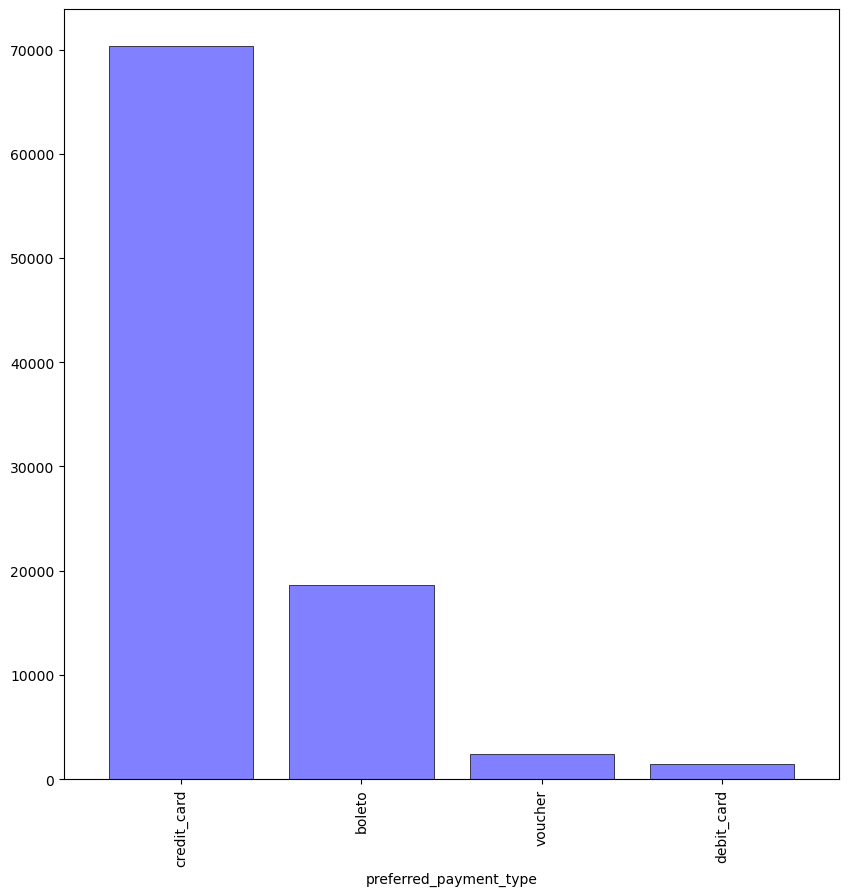

In [21]:
plt.figure(figsize=(10,10))
data.groupby('preferred_payment_type').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8);

On voit ici que le paiment par carte bancaire est très majoritaire.<br>
Je vais donc réduire à deux catégories : *carte bancaire* et *autre*.

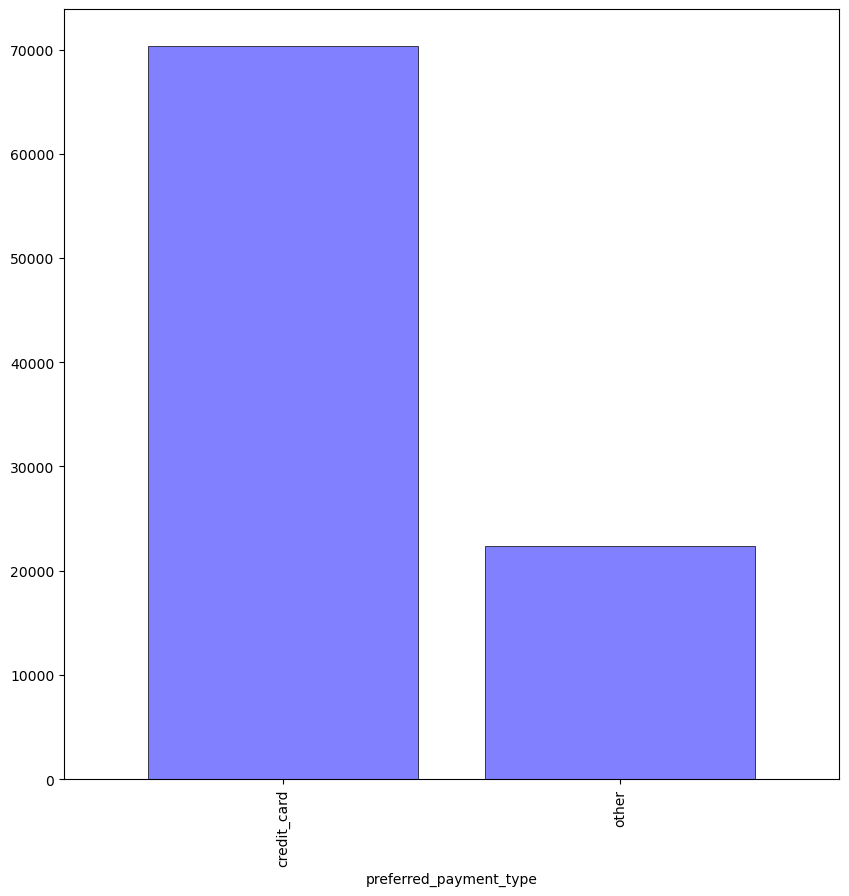

In [22]:
plt.figure(figsize=(10,10))
data['preferred_payment_type'].loc[(data['preferred_payment_type'] == 'boleto') | (data['preferred_payment_type'] == 'voucher') | (data['preferred_payment_type'] == 'debit_card')] = "other"
data.groupby('preferred_payment_type').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8);

- *preferred_category* : 

Il y a 72 catégories différentes.


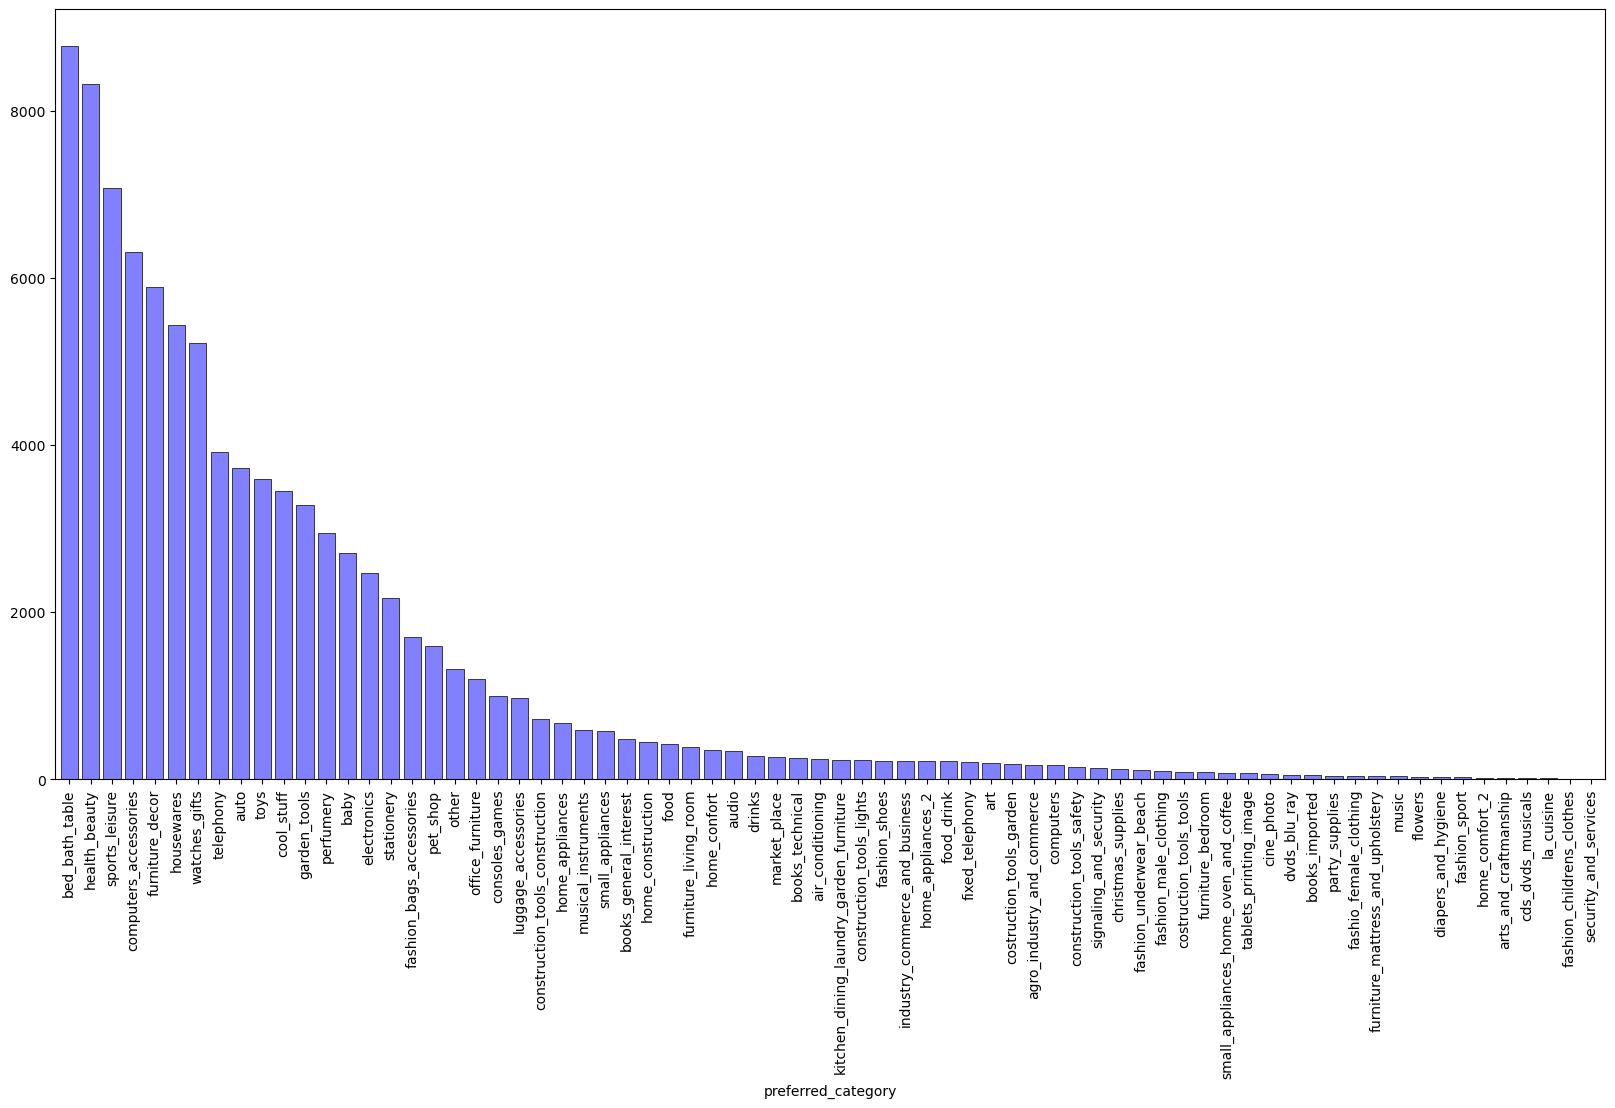

In [23]:
plt.figure(figsize=(20,10))
data.groupby('preferred_category').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8);
print("Il y a", len(data['preferred_category'].unique()), "catégories différentes.")

**Beaucoup trop de catégories, je vais réduire le nombre de catégories comme suit :**

- ***electronics_computers*** :<br>
'telephony',
'electronics',
'tablets_printing_image',
'computers_accessories',
'fixed_telephony',
'computers'

- ***fashion_clothing*** :<br>
'fashion_bags_accessories',
'fashion_underwear_beach',
'fashion_shoes',
'fashion_male_clothing',
'fashion_childrens_clothes',
'fashion_sport',
'luggage_accessories',
'watches_gifts',
'fashio_female_clothing'

- ***home_kitchen_garden*** :<br>
'home_comfort_2',
'small_appliances_home_oven_and_coffee',
'home_confort',
'home_appliances',
'home_construction',
'home_appliances_2',
'furniture_living_room',
'office_furniture',
'furniture_decor',
'kitchen_dining_laundry_garden_furniture',
'furniture_bedroom',
'furniture_mattress_and_upholstery',
'small_appliances',
'bed_bath_table',
'stationery',
'garden_tools',
'housewares',
'construction_tools_construction',
'pet_shop',
'flowers',
'construction_tools_safety',
'christmas_supplies',
'construction_tools_lights',
'costruction_tools_garden',
'costruction_tools_tools',
'air_conditioning',
'la_cuisine'

- ***health_beauty*** :<br>
'health_beauty',
'perfumery'

- ***sports_leisure*** :<br>
'cool_stuff',
'sports_leisure',
'musical_instruments',
'party_supplies',
'arts_and_craftmanship'

- ***books_entertainment*** :<br>
'cds_dvds_musicals',
'cine_photo',
'books_general_interest',
'books_technical',
'books_imported',
'dvds_blu_ray',
'consoles_games',
'audio',
'art',
'books_imported',
'music'

- ***automotive_motorcycle*** :<br>
'auto',
'signaling_and_security'

- ***babies_kids*** :<br>
'baby',
'toys',
'diapers_and_hygiene'

- ***food_drinks*** :<br>
'food_drink',
'food',
'drinks'

- ***other*** :<br>
'other',
'industry_commerce_and_business',
'market_place',
'agro_industry_and_commerce',
'security_and_services

In [24]:
print("Nombre de catégories avant traitement :", len(data['preferred_category'].unique()))

electronics_computers = [
                        'telephony',
                        'electronics',
                        'tablets_printing_image',
                        'computers_accessories',
                        'fixed_telephony',
                        'computers'
                        ]

data['preferred_category'].loc[data['preferred_category'].isin(electronics_computers)] = 'electronics_computers'

fashion_clothing = [
                    'fashion_bags_accessories',
                    'fashion_underwear_beach',
                    'fashion_shoes',
                    'fashion_male_clothing',
                    'fashion_childrens_clothes',
                    'fashion_sport',
                    'luggage_accessories',
                    'watches_gifts',
                    'fashio_female_clothing'
                   ]

data['preferred_category'].loc[data['preferred_category'].isin(fashion_clothing)] = 'fashion_clothing'

home_kitchen_garden = [
                        'home_comfort_2',
                        'small_appliances_home_oven_and_coffee',
                        'home_confort',
                        'home_appliances',
                        'home_construction',
                        'home_appliances_2',
                        'furniture_living_room',
                        'office_furniture',
                        'furniture_decor',
                        'kitchen_dining_laundry_garden_furniture',
                        'furniture_bedroom',
                        'furniture_mattress_and_upholstery',
                        'small_appliances',
                        'bed_bath_table',
                        'stationery',
                        'garden_tools',
                        'housewares',
                        'construction_tools_construction',
                        'pet_shop',
                        'flowers',
                        'construction_tools_safety',
                        'christmas_supplies',
                        'construction_tools_lights',
                        'costruction_tools_garden',
                        'costruction_tools_tools',
                        'air_conditioning',
                        'la_cuisine'
                      ]

data['preferred_category'].loc[data['preferred_category'].isin(home_kitchen_garden)] = 'home_kitchen_garden'

health_beauty = [
                 'health_beauty',
                 'perfumery'
                ]

data['preferred_category'].loc[data['preferred_category'].isin(health_beauty)] = 'health_beauty'

sports_leisure = [
                'cool_stuff',
                'sports_leisure',
                'musical_instruments',
                'party_supplies',
                'arts_and_craftmanship'
                 ]

data['preferred_category'].loc[data['preferred_category'].isin(sports_leisure)] = 'sports_leisure'

books_entertainment = [
                      'cds_dvds_musicals',
                      'cine_photo',
                      'books_general_interest',
                      'books_technical',
                      'books_imported',
                      'dvds_blu_ray',
                      'consoles_games',
                      'audio',
                      'art',
                      'books_imported',
                      'music'
                      ]

data['preferred_category'].loc[data['preferred_category'].isin(books_entertainment)] = 'books_entertainment'

automotive_motorcycle = [
                        'auto',
                        'signaling_and_security'
                        ]

data['preferred_category'].loc[data['preferred_category'].isin(automotive_motorcycle)] = 'automotive_motorcycle'

babies_kids = [
              'baby',
              'toys',
              'diapers_and_hygiene'
              ]

data['preferred_category'].loc[data['preferred_category'].isin(babies_kids)] = 'babies_kids'

food_drinks = [
              'food_drink',
              'food',
              'drinks'
              ]

data['preferred_category'].loc[data['preferred_category'].isin(food_drinks)] = 'food_drinks'

other = [
        'other',
        'industry_commerce_and_business',
        'market_place',
        'agro_industry_and_commerce',
        'security_and_services'
        ]

data['preferred_category'].loc[data['preferred_category'].isin(other)] = 'other'

print("Nombre de catégories après traitement :", len(data['preferred_category'].unique()))


Nombre de catégories avant traitement : 72
Nombre de catégories après traitement : 10


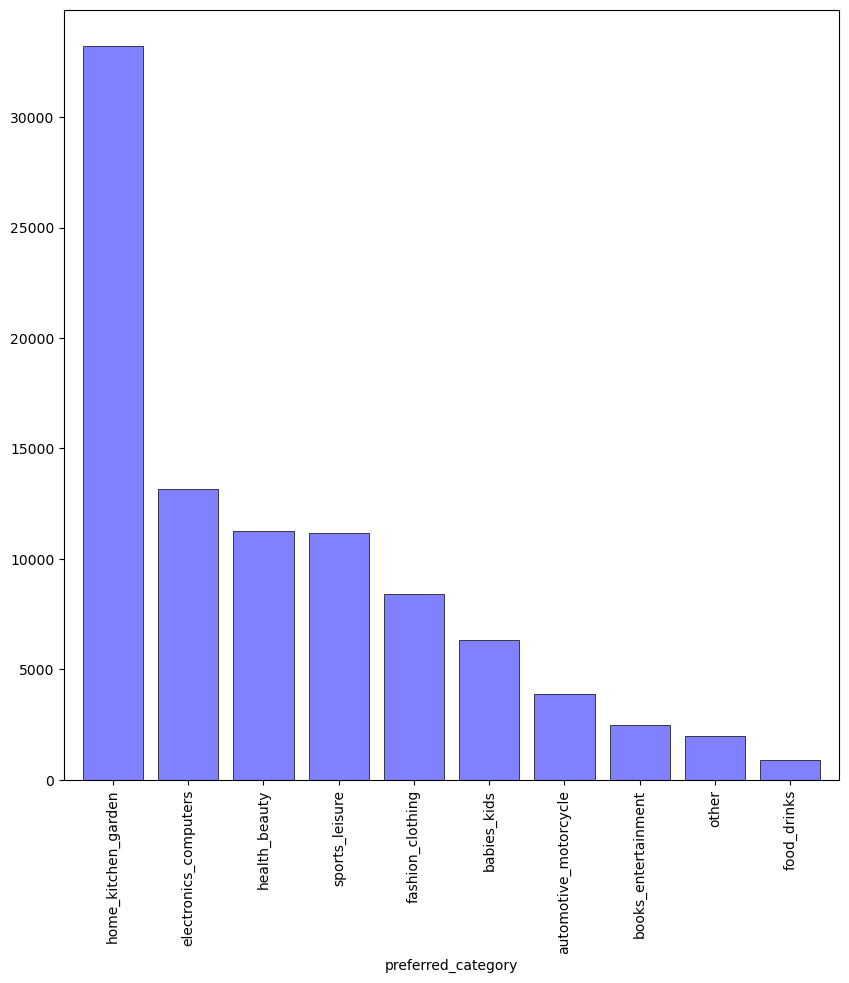

In [25]:
plt.figure(figsize=(10,10))
data.groupby('preferred_category').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8);

In [26]:
display(data)
print("Valeurs nulles dans le dataset :", data.isnull().sum().sum())

,customer_unique_id,customer_lat,customer_lng,orders_number,first_purchase_date,last_purchase_date,recency,frequency,avg_spent,total_spent,preferred_payment_type,avg_payment_installments,shipping_fees_proportion,avg_customer_seller_distance_km,avg_delivery_time,preferred_category,avg_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,-23.340235,-46.830140,1,2018-05-10 10:56:27,2018-05-10 10:56:27,111,111.0,141.90,141.90,credit_card,8.0,8.456660,110.568636,6.0,home_kitchen_garden,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-23.559115,-46.787626,1,2018-05-07 11:11:27,2018-05-07 11:11:27,114,114.0,27.19,27.19,credit_card,1.0,30.489150,22.168333,3.0,health_beauty,4.0
2,0000f46a3911fa3c0805444483337064,-27.542880,-48.633426,1,2017-03-10 21:05:03,2017-03-10 21:05:03,536,536.0,86.22,86.22,credit_card,8.0,19.972164,516.938836,25.0,home_kitchen_garden,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,-1.312214,-48.483159,1,2017-10-12 20:29:41,2017-10-12 20:29:41,320,320.0,43.62,43.62,credit_card,4.0,40.417240,2481.287188,20.0,electronics_computers,4.0
4,0004aac84e0df4da2b147fca70cf8255,-23.505548,-47.469705,1,2017-11-14 19:45:42,2017-11-14 19:45:42,287,287.0,196.89,196.89,credit_card,6.0,8.578394,154.507887,13.0,electronics_computers,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93345,fffcf5a5ff07b0908bd4e2dbc735a684,-8.362511,-36.562343,1,2017-06-08 21:00:36,2017-06-08 21:00:36,446,446.0,2067.42,2067.42,credit_card,10.0,12.029970,1996.470471,27.0,health_beauty,5.0
93346,fffea47cd6d3cc0a88bd621562a9d061,-12.217395,-38.959308,1,2017-12-10 20:07:56,2017-12-10 20:07:56,261,261.0,84.58,84.58,credit_card,1.0,23.279735,1527.201720,30.0,babies_kids,4.0
93347,ffff371b4d645b6ecea244b27531430a,-11.834552,-55.508110,1,2017-02-07 15:49:16,2017-02-07 15:49:16,567,567.0,112.46,112.46,credit_card,1.0,20.060466,1526.116170,14.0,automotive_motorcycle,5.0
93348,ffff5962728ec6157033ef9805bacc48,-21.126568,-41.672806,1,2018-05-02 15:17:41,2018-05-02 15:17:41,118,118.0,133.69,133.69,credit_card,5.0,13.980103,637.858806,11.0,fashion_clothing,5.0


Valeurs nulles dans le dataset : 0


### **Vérification du type de chaque colonne**

In [27]:
print("Type des différentes variables :")
data.dtypes

Type des différentes variables :


customer_unique_id                         object
customer_lat                              float64
customer_lng                              float64
orders_number                               int64
first_purchase_date                datetime64[ns]
last_purchase_date                 datetime64[ns]
recency                                     int64
frequency                                 float64
avg_spent                                 float64
total_spent                               float64
preferred_payment_type                     object
avg_payment_installments                  float64
shipping_fees_proportion                  float64
avg_customer_seller_distance_km           float64
avg_delivery_time                         float64
preferred_category                         object
avg_review_score                          float64
dtype: object

Pas de problème ici.

### **Vérification des valeurs prises par les variables**

In [28]:
print('Valeurs prises par les variables avant traitement : ')
display(data.describe())

Valeurs prises par les variables avant traitement : 


,customer_lat,customer_lng,orders_number,recency,frequency,avg_spent,total_spent,avg_payment_installments,shipping_fees_proportion,avg_customer_seller_distance_km,avg_delivery_time,avg_review_score
count,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000
mean,-21.192936,-46.191889,1.033543,236.780756,234.644806,160.061105,164.954233,2.913446,19.519871,600.907084,12.062541,4.153647
std,5.604305,4.051277,0.209553,152.589336,151.794657,218.250605,225.057315,2.689083,12.311323,593.178139,9.465400,1.280116
min,-33.689948,-72.668881,1.000000,0.000000,0.000000,9.590000,9.590000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-23.589481,-48.119196,1.000000,113.000000,113.000000,62.310000,63.010000,1.000000,10.496247,189.759568,6.000000,4.000000
50%,-22.922759,-46.631239,1.000000,218.000000,215.000000,105.525000,107.780000,2.000000,16.723122,433.546627,10.000000,5.000000
75%,-20.140216,-43.653556,1.000000,345.000000,341.000000,176.340000,182.320000,4.000000,25.809863,798.269264,15.000000,5.000000
max,42.184003,-8.723762,15.000000,694.000000,694.000000,13664.080000,13664.080000,24.000000,95.545073,8677.911622,208.000000,5.000000


- *total_spent*

Cette variable peut atteindre plus de 13000. Bien que ceci soit plausible, ces rares cas de figure risquent de perturber nos modèles à venir, je décide de remplacer les valeurs supérieures à 5000 par la médiane (distribution non symétrique).

In [29]:
data['total_spent'].loc[data['total_spent'] > 5000] = data['total_spent'].median()
# Suite à cette modification, je dois recalculer avg_spent
data['avg_spent'] = data['total_spent'] / data['orders_number']

- *avg_payment_installments*

Cette variable peut monter jusqu'à 24. Bien qu'il soit possible que certains vendeurs proposent des paiements sur 24 mois, ces rares cas de figure risquent de perturber nos modèles à venir, je décide de remplacer les valeurs supérieures à 12 par la médiane (distribution non symétrique).

In [30]:
data['avg_payment_installments'].loc[data['avg_payment_installments'] > 12] = data['avg_payment_installments'].median()

Il y a quelques cas où *avg_payment_installments* = 0, c'est aberrant, je remplace par 1.

In [31]:
data['avg_payment_installments'].loc[data['avg_payment_installments'] < 1] = 1

- *shipping_fees_proportion*

Cette variable peut monter jusqu'à 95%. Après vérifications sur les commandes concernées, ceci est atypique, mais pas aberrant : matériaux peu onéreux mais très lourds.<br>
Cependant, ces rares cas de figure risquent de perturber nos modèles à venir, je décide de remplacer les valeurs supérieures à 70% par la médiane (distribution non symétrique).

In [32]:
data['shipping_fees_proportion'].loc[data['shipping_fees_proportion'] > 70] = data['shipping_fees_proportion'].median()

- *avg_customer_seller_distance_km*

La plus grande ligne droite possible au Brésil est d'environ 4300 km.<br>
Pour les quelques valeurs qui dépassent cette limite, je remplace par la mediane (distribution non symétrique).

In [33]:
data['avg_customer_seller_distance_km'].loc[data['avg_customer_seller_distance_km'] > 4300] = data['avg_customer_seller_distance_km'].median()

- *avg_delivery_time*

Je pars du principe que quand la valeur du délais de livraison est supérieur à 60, c'est que l'information que la commande a bien été livrée est parvenue tardivement.<br>
Je remplace par la médiane (distribution non symétrique).

In [34]:
data['avg_delivery_time'].loc[data['avg_delivery_time'] > 60] = data['avg_delivery_time'].median()

Quand *avg_delivery_time* est < à 1, c'est aberrant, je remplace par 1.

In [35]:
data['avg_delivery_time'].loc[data['avg_delivery_time'] < 1] = 1

In [36]:
print('Valeurs prises par les variables après traitement : ')
display(data.describe())

Valeurs prises par les variables après traitement : 


,customer_lat,customer_lng,orders_number,recency,frequency,avg_spent,total_spent,avg_payment_installments,shipping_fees_proportion,avg_customer_seller_distance_km,avg_delivery_time,avg_review_score
count,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000,92746.000000
mean,-21.192936,-46.191889,1.033543,236.780756,234.644806,159.588098,164.440988,2.887380,19.423973,600.665429,11.838682,4.153647
std,5.604305,4.051277,0.209553,152.589336,151.794657,208.907907,214.975194,2.621501,12.104951,592.017439,8.332400,1.280116
min,-33.689948,-72.668881,1.000000,0.000000,0.000000,9.590000,9.590000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,-23.589481,-48.119196,1.000000,113.000000,113.000000,62.310000,63.010000,1.000000,10.496247,189.759568,6.000000,4.000000
50%,-22.922759,-46.631239,1.000000,218.000000,215.000000,105.520000,107.780000,2.000000,16.722934,433.542414,10.000000,5.000000
75%,-20.140216,-43.653556,1.000000,345.000000,341.000000,176.330000,182.290000,4.000000,25.701938,798.174926,15.000000,5.000000
max,42.184003,-8.723762,15.000000,694.000000,694.000000,4764.340000,4764.340000,12.000000,69.989077,3927.406027,60.000000,5.000000


## **Export du dataset global pour pouvoir les utiliser dans d'autres notebooks**

In [37]:
# Export du dataset data
if os.path.isfile('data_global.xlsx') == False:
    data.to_excel('data_global.xlsx', index = False)
    print("Fichier créé.")
else:
    print("Le fichier 'data_global.xlsx' existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")